In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
np.arange(1,20)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

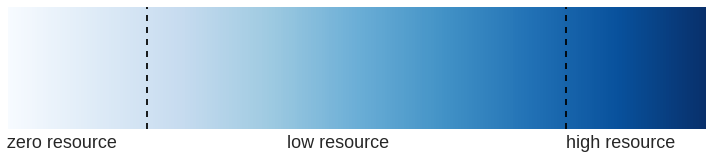

In [3]:
# sns.palplot(sns.color_palette("Blues", 10))

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(10, 2), sharex=True)

# Generate some sequential data
x = np.arange(1,1001)
y1 = 2*np.ones(1000)
# sns.barplot(x, y1, palette="Blues_d", edgecolor='0', ax=ax1, width=1)
plt.bar(x, y1, width=1, color=[plt.cm.Blues((1.0*i/len(x))) for i in x], edgecolor='')
# ax1.set_ylabel("Sequential")
ax1.set_xlim(1,1000)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(0, -.3, r'zero resource', fontsize=18)
ax1.text(400, -.3, r'low resource', fontsize=18)
ax1.text(800, -.3, r'high resource', fontsize=18)
ax1.axvline(200, linestyle='--', color='k')
ax1.axvline(800, linestyle='--', color='k')
f.tight_layout()
f.savefig("resource.png")

# # Center the data to make it diverging
# y2 = y1 - 5
# sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
# ax2.set_ylabel("Diverging")

In [4]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [5]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [6]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [43]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [46]:
os.path.exists(mt_gold_pred_dict_fname), mt_gold_pred_dict_fname, os.path.exists(mt_pseudo_eval_dict_fname), mt_pseudo_eval_dict_fname

(True,
 u'../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/mt_gold_pred_dict.p',
 True,
 u'../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/mt_pseudo_eval_dict.p')

In [9]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [10]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [11]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [14]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+------------------------+---------------------------------------------------+
| pair id |  nid  |     ES transcript      |                   EN translation                  |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19997 | CINCO OCHO CUATRO SEIS |                FIVE EIGHT FOUR SIX                |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19998 | CINCO OCHO CUATRO SEIS | EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT |
|         |       |                        |   THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT  |
|         |       |                        |  FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE |
|         |       |                        |                  WASHINGTON CODE                  |
+---------+-------+------------------------+---------------------------------------------------+


## Cluster analysis

In [15]:
train_segment_list_fname, dev_segment_list_fname

(u'../files-train-segments-sf-10.txt', u'../files-dev-segments-sf-10.txt')

In [16]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [17]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [18]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [19]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

597
643
1374


In [20]:
2674 + 650

3324

In [51]:
dev_pwords = []
train_pwords = []
oov_pwords = []
for did in dev_sids:
    dev_pwords.extend(feats_dict[did])
for tid in train_sids:
    train_pwords.extend(feats_dict[tid])
set_train_pwords = set(train_pwords)
oov_pwords = [cid for cid in dev_pwords if cid not in set_train_pwords and cid != "-1"]
missing_train_words = [cid for cid in train_pwords if cid == "-1"]
missing_words = [cid for cid in dev_pwords if cid == "-1"]
out_line = PrettyTable(["Total words", "oov", "Missing", "oov + missing"])
out_line.add_row([len(dev_pwords), len(oov_pwords), \
                  len(missing_words), \
                 len(oov_pwords) + len(missing_words)])
print(out_line)

out_line = PrettyTable(["total vocab", "oov vocab"])
out_line.add_row([len(set(dev_pwords)), len(set(oov_pwords))])
print(out_line)
print(len(missing_train_words))

+-------------+-----+---------+---------------+
| Total words | oov | Missing | oov + missing |
+-------------+-----+---------+---------------+
|     1699    | 643 |   325   |      968      |
+-------------+-----+---------+---------------+
+-------------+-----------+
| total vocab | oov vocab |
+-------------+-----------+
|     1255    |    597    |
+-------------+-----------+
3036


In [52]:
oov_pwords[:5]

['226', '11226', '10934', '10941', '10954']

In [61]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 658
translations missing for: 1


In [72]:
feats_dict['001.001']

['8']

In [89]:
k = 5
num_en_oov = sum([mt_pseudo_eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                  if len(set(feats_dict[sid])-set(oov_pwords)) == 0])
num_en = sum([mt_pseudo_eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
num_en_missing = sum([mt_pseudo_eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                  if feats_dict[sid] == ['-1']])

num_en_pred = sum([mt_pseudo_eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
num_en_corr_pred = sum([mt_pseudo_eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

print(num_en_oov, num_en_missing, num_en, (num_en-num_en_oov-num_en_missing)/num_en)
print(num_en_pred, num_en_pred/num_en, num_en_corr_pred/(num_en-num_en_missing-num_en_oov))

272 837 2899 0.617454294584
2810 0.969299758537 0.0972067039106


In [22]:
len(dev_pwords), len([i for i in dev_pwords if i != '-1']), len(set([i for i in dev_pwords if i != '-1']))

(1699, 1374, 1254)

In [23]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
# clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [24]:
clusters[0], nodes_dict[1], nodes_dict[2]

([1, 2],
 Node(file='001', seg='001.033', start=94, end=149, es=('EL', 'RADIOTERAPISTA'), es_cnt=('RADIOTERAPISTA',)),
 Node(file='001', seg='001.033', start=170, end=224, es=('RADIOTERAPISTA',), es_cnt=('RADIOTERAPISTA',)))

In [25]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(10)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim
16210,19997,19998,0.999,1,1,0.266667
8637,34387,34388,0.999,1,1,0.095238
598,17526,37544,0.999,1,1,0.047619
14292,58275,58287,0.999,1,1,0.222222
3582,14075,14076,0.999,1,1,1.000000
10454,51185,51186,0.999,1,1,0.166667
21587,15745,15746,0.999,1,1,1.000000
1275,19551,19552,0.999,1,1,0.250000
24760,2567,2568,0.999,0,0,0.000000
8186,353,354,0.999,1,1,0.000000


In [26]:
clusters_df['cross_file'] = clusters_df.apply(lambda row: len(set(row['sids'])) > 1, axis=1)

In [27]:
clusters_df['fid_min'] = clusters_df.apply(lambda row: min(row['sids']), axis=1)

In [28]:
clusters_df['fid_max'] = clusters_df.apply(lambda row: max(row['sids']), axis=1)

In [29]:
clusters_df['oov'] = clusters_df.apply(lambda row: max(row['sids']) not in train_fids and \
                                                    min(row['sids']) in dev_fids, axis=1)

In [30]:
len([cid for cid in clusters_stats['sids'] if len(set(cid)) > 1])

15011

In [31]:
clusters_df.head(10)

,dev_depth,fids,is_dev,is_train,most_common,oov,purity,sids,train_depth,words,cross_file,fid_min,fid_max
0,0,"[001, 001]",False,False,radioterapista,False,1.000000,"[001.033, 001.033]",0,"[radioterapista, radioterapista]",False,001.033,001.033
1,0,"[001, 001]",False,False,conoce,False,0.500000,"[001.084, 001.084]",0,"[conversa, conoce]",False,001.084,001.084
2,0,"[001, 001]",False,False,maneras,False,0.333333,"[001.159, 001.159]",0,"[mandado, todas, maneras]",False,001.159,001.159
3,0,"[001, 001]",False,False,ver,False,0.500000,"[001.224, 001.224]",0,"[vamos, ver, vamos, ver]",False,001.224,001.224
4,0,"[001, 001]",False,False,año,False,0.666667,"[001.249, 001.249]",0,"[año, ser, año]",False,001.249,001.249
5,0,"[001, 001]",False,False,interpretación,False,0.400000,"[001.141, 001.143]",0,"[necesita, interpretación, ley, necesita, inte...",True,001.141,001.143
6,0,"[001, 001]",False,False,interpretación,False,1.000000,"[001.141, 001.143]",0,"[interpretación, interpretación]",True,001.141,001.143
7,0,"[001, 001, 001, 009]",False,False,mandar,False,0.285714,"[001.001, 001.003, 001.260, 009.096]",0,"[mandado, dónde, mandado, vas, mandar, vamos, ...",True,001.001,009.096
8,0,"[001, 001, 023]",False,False,averiguarlo,False,0.250000,"[001.229, 001.233, 023.080]",0,"[averiguar, averiguarlo, dice, dijo]",True,001.229,023.080
9,0,"[001, 001]",False,False,variaciones,False,0.500000,"[001.021, 001.027]",0,"[operaciones, variaciones]",True,001.021,001.027


In [32]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(15011, 15533)

In [33]:
len(clusters_df[clusters_df.is_dev])

1254

In [34]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

597

In [35]:
# !ls ../../../ZRTools/exp/callhome/tmpwav/

In [36]:
Audio('../../../ZRTools/exp/callhome/tmpwav/0058.wav')

In [37]:
k = 1
uttr = "010.169"
# uttr = "011.178"
# uttr = "002.008"

In [38]:
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['es']]))
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['en_cnt']]))

AH BUENO ESA ES LA CUESTIóN OYE BUENO Y
OH WELL 'S PROBLEM HEY WELL


In [39]:
print(" ".join([w.decode("utf-8") for w in gold_feats_dict[uttr]])),
print(" ".join([w.decode("utf-8") for w in feats_dict[uttr]]))

AH BUENO CUESTIóN OYE BUENO
1354


In [40]:
# pseudo_probs_dict['1354']

In [41]:
print(" ".join([w.decode("utf-8") for w in mt_gold_pred_dict[k][uttr]])),
print(" ".join([w.decode("utf-8") for w in mt_pseudo_pred_dict[k][uttr]]))

OH GOOD SEEING HEY GOOD



In [ ]:
[(key, v['t']) for key,v in mt_pseudo_eval_dict['dev'][k].items() if type(v) == dict and v['cp'] == 1]

In [ ]:
feats_dict['001.001']

In [ ]:
print("%03d" % (10,))

In [ ]:
aaa = [0.341, 0.185, 0.121]
bbb = [0.583, 0.454, 0.354]

In [ ]:
for x, y in zip(aaa, bbb):
    print((y-x)/x * 100)

## Calculate duration in dev, test, and training sets

In [ ]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [ ]:
dur = {"tot":{}, "ge500ms":{}}

In [ ]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [ ]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

In [ ]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [ ]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

In [ ]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

In [ ]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, t_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(t_files, len(test_dur_500ms_list))

## Fisher

In [ ]:
fish_path = "../../fisher/"
fish_flist_fname = "../../fisher/goodfiles-gdfa.txt"
fish_es_align_path = os.path.join(fish_path, "wav2es-word-final")
fish_subfolders = [os.path.join(fish_es_align_path, f) for f in map(str, range(8))]

In [ ]:
es_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es']]
es_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es_cnt']]
en_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en']]
en_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en_cnt']]

In [ ]:
print(len(es_words), len(set(es_words)))
print(len(es_cnt_words), len(set(es_cnt_words)))
print(len(en_words), len(set(en_words)))
print(len(en_cnt_words), len(set(en_cnt_words)))

In [ ]:
def fisher_get_details(transcript_path):
    es_words = []
    fids = []
    dur = 0
    dur_500ms = 0
    for fname in [f for f in os.listdir(transcript_path) if f.endswith(".es")]:
        fids.append(os.path.splitext(fname)[0].split("_")[2])
        with open(os.path.join(transcript_path, fname), "r") as in_f:
            for line in in_f:
                line_items = line.strip().split()
                start, end = map(float, line_items[1:])
                es_words.append(line_items[0])
                curr_dur = end-start
                dur += curr_dur
                dur_500ms += curr_dur if curr_dur >= 0.5 else 0
    print("finished")
    return es_words, fids, dur, dur_500ms
                
            

In [ ]:
# fish_es, fish_fids, fish_dur, fish_dur_500ms = fisher_get_details(fish_subfolders[0])
fish_es = []
fish_fids = set()
fish_dur = 0
fish_dur_500ms = 0
for subfolder in fish_subfolders[2:3]:
    temp_es, temp_fids, temp_dur, temp_dur_500ms = fisher_get_details(subfolder)
    fish_es.extend(temp_es)
    fish_fids |= set(temp_fids)
    fish_dur += temp_dur
    fish_dur_500ms += temp_dur_500ms
    print("missing es: %d" % len(set(es_words)-set(temp_es)))
    print("dur, total: %.2f, 500ms: %.2f" % (temp_dur / 3600, temp_dur_500ms / 3600))

In [ ]:
fish_es_cnt = [w for w in list(set(fish_es)) if w.lower().decode("utf-8") not in set(stopwords.words('spanish'))]
    
print("#es: %d, set: %d, #fids: %d" % (len(fish_es), len(set(fish_es)), len(set(fish_fids))))
print("tots dur: %.2f, min 500ms dur: %.2f" %(fish_dur / 3600, fish_dur_500ms / 3600))
print("# es cnt: %d," % (len(set(fish_es_cnt))))

In [ ]:
print("missing es\t%d, overlap: %.1f%%" % (len(set(es_words) - set(fish_es)), (len(set(es_words) & set(fish_es)) / len(set(es_words)) * 100)))
print("missing es cnt\t%d" % len(set(es_cnt_words) - set(fish_es_cnt)))

In [ ]:
len(fish_fids)

In [ ]:
[os.path.splitext(f)[0] for f in os.listdir(os.path.join(fish_es_align_path, "0"))[:5]]

In [ ]:
train_segment_list_fname, dev_segment_list_fname